<a href="https://colab.research.google.com/github/SeongBeomLEE/RecsysTutorial/blob/main/AutoRec/AutoRec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings

warnings.filterwarnings(action='ignore')

data_dir = '/content/drive/MyDrive/RecsysTutorial/Data/MovieLens/'
model_dir = '/content/drive/MyDrive/RecsysTutorial/Model/'

# 데이터 확인

In [2]:
ratings_df = pd.read_csv(data_dir + 'ratings.csv')
ratings_df.head(10)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [3]:
num_user = ratings_df['userId'].nunique()
num_item = ratings_df['movieId'].nunique()

sparsity = 1 - len(ratings_df) / (num_user * num_item)

print(f'전체 User 수: {num_user}')
print(f'전체 Item 수: {num_item}')
print(f'행렬의 희소성: {sparsity:.4f}')

전체 User 수: 671
전체 Item 수: 9066
행렬의 희소성: 0.9836


Text(0.5, 1.0, 'Rating distribution')

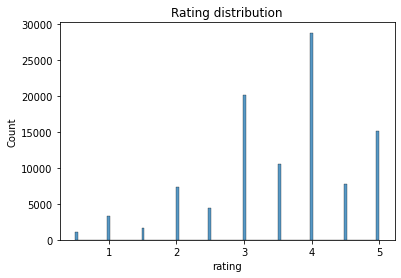

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(ratings_df['rating'])
plt.title('Rating distribution')

# 데이터셋 제작

In [5]:
def split_data(df, test_ratio = 0.1):
    user_id_li = df['userId'].unique()
    mask = []
    for user_id in user_id_li:
        _df = df[df['userId'] == user_id]
        mask += [True if x == 1 else False for x in np.random.uniform(0, 1, (len(_df))) < 1 - test_ratio]
    neg_mask = [not x for x in mask]

    train_data, test_data = df[mask], df[neg_mask]
    return train_data, test_data

train_df, val_df = split_data(df = ratings_df)

In [6]:
not_in_val_user_num = len(set(val_df['userId'].unique().tolist()) - set(train_df['userId'].unique().tolist()))
not_in_val_item_num = len(set(val_df['movieId'].unique().tolist()) - set(train_df['movieId'].unique().tolist()))

print(f'학습용 데이터에 없는 유저의 수 : {not_in_val_user_num}')
print(f'학습용 데이터에 없는 영화의 수 : {not_in_val_item_num}')
print(f'학습용 데이터의 수: {len(train_df)}, 평가용 데이터의 수: {len(val_df)}')

학습용 데이터에 없는 유저의 수 : 0
학습용 데이터에 없는 영화의 수 : 297
학습용 데이터의 수: 90078, 평가용 데이터의 수: 9926


In [7]:
user_encoder, user_decoder = {}, {}
for idx, user_id in enumerate(ratings_df['userId'].unique()):
    user_encoder[user_id] = idx
    user_decoder[idx] = user_id

item_encoder, item_decoder = {}, {}
for idx, item_id in enumerate(ratings_df['movieId'].unique()):
    item_encoder[item_id] = idx
    item_decoder[idx] = item_id

In [8]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, df, user_encoder, item_encoder):
        self.df = df
        self.user_encoder, self.item_encoder, = user_encoder, item_encoder
        self.num_user, self.num_item = len(self.user_encoder), len(self.item_encoder)
        self.user = [self.user_encoder[i] for i in self.df['userId'].tolist()]
        self.item = [self.item_encoder[i] for i in self.df['movieId'].tolist()]
        self.rating = self.df['rating'].tolist()
        self.mat = self.make_mat()

    def make_mat(self):
        mat = np.zeros((self.num_item, self.num_user)) - 1
        for user, item, rating in zip(self.user, self.item, self.rating):
            mat[item][user] = rating

        return mat

    def __len__(self):
        return len(self.mat)

    def __getitem__(self, idx):
        mat = torch.tensor(self.mat[idx]).float()

        return mat

# 모델 정의

In [31]:
class AutoRec(nn.Module):
    def __init__(self, num, num_factor):
        super(AutoRec, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num, num_factor),
            nn.Sigmoid(),
            nn.Linear(num_factor, num_factor // 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(num_factor // 2, num_factor),
            nn.Sigmoid(),
            nn.Linear(num_factor, num),
        )

    def forward(self, mat):
        latent = self.encoder(mat)
        recont_mat = self.decoder(latent)

        return recont_mat

# 학습 설정

In [76]:
def train(model, train_loader):
    model.train()
    train_loss = 0

    for mat in train_loader:
        mat = mat.to(device)
        mask = mat >= 0
        one_mask = mat == -1
        mat[one_mask] = 3.0

        optimizer.zero_grad()
        output = model(mat)

        loss = criterion(output[mask], mat[mask])

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    train_loss = train_loss / len(train_loader)

    return train_loss


def evaluate(model, test_loader):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for mat in test_loader:
            mat = mat.to(device)
            mask = mat >= 0
            one_mask = mat == -1
            mat[one_mask] = 3.0

            output = model(mat)

            loss = criterion(output[mask], mat[mask])

            test_loss += loss.item()

    test_loss = test_loss / len(test_loader)

    return test_loss

# 학습

In [136]:
num_factor = 64
batch_size = 512
epochs = 100
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
lr = 0.005

In [137]:
model = AutoRec(num = num_user, num_factor = num_factor).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

train_dataset = CustomDataset(df = ratings_df, user_encoder = user_encoder, item_encoder = item_encoder)
val_dataset = CustomDataset(df = val_df, user_encoder = user_encoder, item_encoder = item_encoder)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False, drop_last = False)

In [138]:
best_metric = 1

for epoch in range(1, epochs + 1):
    train_loss = train(model, train_loader)
    val_loss = evaluate(model, val_loader)

    print(f"[EPOCH: {epoch}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_metric:
        best_metric = val_loss
        torch.save(model.state_dict(), model_dir + f'AutoRec.pt')

[EPOCH: 1], Train Loss: 5.2871, Val Loss: 1.9630
[EPOCH: 2], Train Loss: 1.2911, Val Loss: 0.9983
[EPOCH: 3], Train Loss: 0.9737, Val Loss: 1.0126
[EPOCH: 4], Train Loss: 0.9363, Val Loss: 0.9861
[EPOCH: 5], Train Loss: 0.9313, Val Loss: 0.9888
[EPOCH: 6], Train Loss: 0.9325, Val Loss: 0.9775
[EPOCH: 7], Train Loss: 0.9326, Val Loss: 0.9775
[EPOCH: 8], Train Loss: 0.9356, Val Loss: 0.9863
[EPOCH: 9], Train Loss: 0.9371, Val Loss: 0.9841
[EPOCH: 10], Train Loss: 0.9353, Val Loss: 0.9954
[EPOCH: 11], Train Loss: 0.9364, Val Loss: 0.9890
[EPOCH: 12], Train Loss: 0.9385, Val Loss: 0.9669
[EPOCH: 13], Train Loss: 0.9410, Val Loss: 0.9955
[EPOCH: 14], Train Loss: 0.9373, Val Loss: 0.9899
[EPOCH: 15], Train Loss: 0.9410, Val Loss: 0.9816
[EPOCH: 16], Train Loss: 0.9375, Val Loss: 0.9966
[EPOCH: 17], Train Loss: 0.9410, Val Loss: 0.9957
[EPOCH: 18], Train Loss: 0.9417, Val Loss: 1.0095
[EPOCH: 19], Train Loss: 0.9406, Val Loss: 0.9947
[EPOCH: 20], Train Loss: 0.9402, Val Loss: 1.0004
[EPOCH: 2

현재 만들어진 모델은 user-based 이며 행렬을 전치하여 모델을 학습시키면 item-based 모델을 만들 수 있다. 

In [ ]:
for mat in val_loader:
    mat = mat.to(device)
    mat[mat == -1] = 0
    output = model(mat)
    print(output)
    break

In [140]:
true_max_idx = np.argmax(mat[0].detach().cpu().numpy().reshape(-1), axis = 0)

In [141]:
pred_max_idx = np.argmax(output[0].detach().cpu().numpy().reshape(-1), axis = 0)

In [142]:
mat[0].detach().cpu().numpy().reshape(-1)[true_max_idx]

4.0

In [143]:
mat[0].detach().cpu().numpy().reshape(-1)[pred_max_idx]

0.0

In [144]:
output[0].detach().cpu().numpy().reshape(-1)[true_max_idx]

4.3162775

In [145]:
output[0].detach().cpu().numpy().reshape(-1)[pred_max_idx]

5.1821327